<a href="https://colab.research.google.com/github/earlybyrd/bets/blob/main/nflml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NFL Games Prediction using Machine Learning

Inspired by [Can You Beat FiveThirtyEight’s NFL Forecasts?](https://projects.fivethirtyeight.com/2018-nfl-forecasting-game/), I wanted to use machine learning with publicly available data to make a **probabilistic forecast** for each NFL game.

More specifically, these forecast can be used to bet on NFL games and make a consistent profit. We will be focusing on the **line bet** by simply selecting the winners (different from betting on the spreads).

It is important that the models give us a confidence probability of the winners so that we can decide whether to use the prediction or not. For example, if the model predicts for a particular game that the Minnesota Vikings have a 52% chance of winning, we might not want to place a bet on this. On the other hand, if the model is 90% confident that the Minnesota Vikings will win, we should consider placing a bet (given that the overall performance of the model is "good").

### Data Sources
* Elo Data - https://github.com/fivethirtyeight/data/tree/master/nfl-elo
* NFL historic game and betting info - https://www.kaggle.com/tobycrabtree/nfl-scores-and-betting-data/home

## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime, requests
from datetime import datetime,timedelta,timezone,time
from calendar import THURSDAY,FRIDAY,SATURDAY,SUNDAY,MONDAY,TUESDAY
import seaborn as sns

# required machine learning packages
from sklearn import model_selection
from sklearn.feature_selection import RFE
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV as CCV
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import json
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

## Load and Clean Data

In [ ]:
# get and save elo data
path = "./drive/MyDrive/nfl_model/data/"
elo_url = 'https://raw.githubusercontent.com/Neil-Paine-1/NFL-elo-ratings/main/NFL-elo-ratings.csv'
elo_df = pd.read_csv(elo_url, index_col=0)
games_elo = elo_df[['date','season','neutral','playoff','team1','team2','elo1_pre','elo2_pre','elo_prob1',
                       'elo_prob2','elo1_post','elo2_post','score1','score2']]

games_elo.to_csv(path+"nfl_elo.csv", index=False)

In [ ]:
# loading CSV files downloaded from Kaggle
# path = "./drive/MyDrive/nfl_model/data/"
df = pd.read_csv(path + "spreadspoke_scores.csv")
teams = pd.read_csv(path + "nfl_teams.csv")
teams_clean = pd.read_csv(path + "nfl_teams_clean.csv")
# games_elo = pd.read_csv(path + "nfl_elo.csv")

In [ ]:

print(len(df.index))

11345


In [ ]:
# get dates
football_days = [THURSDAY, FRIDAY, SATURDAY, SUNDAY, MONDAY,TUESDAY]
today = datetime.today().date()


last_week_football_dates = []
this_week_football_dates = []
for football_day in football_days:
  last_week_offset = (today.weekday() - football_day) % 7
  this_week_offset = (football_day - today.weekday()) % 7


  last_week_football_datetime = today - timedelta(days=last_week_offset)
  this_week_football_datetime = today + timedelta(days=this_week_offset)

  # Convert this_week_football_datetime to datetime.datetime object

  this_week_football_datetime = datetime.combine(this_week_football_datetime, datetime.max.time())

  # Now you can add timezone information
  this_week_football_datetime = this_week_football_datetime.replace(tzinfo=timezone.utc)

  last_week_football_date = last_week_football_datetime.strftime('%Y-%m-%d')
  last_week_football_dates.append(last_week_football_date)
  this_week_football_date = this_week_football_datetime.strftime('%Y-%m-%dT%H:%M:%SZ')
  this_week_football_dates.append(this_week_football_date)

# 2024-10-11T00:00:00Z


print(last_week_football_dates)
print(this_week_football_dates)

['2024-10-17', '2024-10-18', '2024-10-19', '2024-10-20', '2024-10-21', '2024-10-22']
['2024-10-24T23:59:59Z', '2024-10-25T23:59:59Z', '2024-10-26T23:59:59Z', '2024-10-27T23:59:59Z', '2024-10-28T23:59:59Z', '2024-10-29T23:59:59Z']


In [ ]:
scores_for_last_week = []
for football_date in last_week_football_dates:

  # Convert to datetime object
  date_obj = datetime.strptime(football_date, "%Y-%m-%d")

  # Format the date object to the new format
  spread_spoke_date_str = date_obj.strftime("%-m/%-d/%y")

  games_response = requests.get(f'https://v1.american-football.api-sports.io/games?date={football_date}&league=1&timezone=America/Chicago', headers={'x-rapidapi-key':'e8d772eeb78727eb68c4bdddbed11f88'})
  if games_response.status_code == 200:
    if len(games_response.json()['response']) > 0:
      games = games_response.json()['response']
      for game in games:
        team_home = game['teams']['home']['name']
        team_away = game['teams']['away']['name']
        score_home = game['scores']['home']['total']
        score_away = game['scores']['away']['total']
        scores_for_last_week.append(
            {
                'schedule_date': spread_spoke_date_str,
                'team_home': team_home,
                'score_home': score_home,
                'score_away': score_away,
                'team_away': team_away,
            }
        )

scores_for_last_week_df = pd.DataFrame(scores_for_last_week)



In [ ]:
#get odds for next week
api_key = '245fb6752c0972d69550991579c0d2f0'
from_date = this_week_football_dates[0]
to_date = this_week_football_dates[len(this_week_football_dates) - 1]
print(from_date)
print(to_date)
#https://the-odds-api.com/liveapi/guides/v4/
print(f'https://api.the-odds-api.com/v4/sports/americanfootball_nfl/odds?apiKey={api_key}&regions=us&markets=h2h,spreads,totals&bookmakers=bovada&oddsFormat=american&commenceTimeFrom={from_date}&commenceTimeTo={to_date}')
odds_response = requests.get(f'https://api.the-odds-api.com/v4/sports/americanfootball_nfl/odds?apiKey={api_key}&regions=us&markets=h2h,spreads,totals&bookmakers=bovada&oddsFormat=american&commenceTimeFrom={from_date}&commenceTimeTo={to_date}')
print(odds_response)
if odds_response.status_code == 200:
  odds_for_this_week = []
  odds = odds_response.json()

  for odd in odds:
    team_home = odd['home_team']
    team_away = odd['away_team']
    spread_favorite = 0.0
    over_under_line = 0.0
    team_favorite = ''
    bovada_market = odd['bookmakers'][0]['markets']

    for market in bovada_market:

      if market['key'] == 'totals':
        over_under_line = market['outcomes'][0]['point']

      if market['key'] == 'spreads':
        if market['outcomes'][0]['point'] < 0:
          spread_favorite = market['outcomes'][0]['point']
          team_favorite = market['outcomes'][0]['name']
        else:
          spread_favorite = market['outcomes'][1]['point']
          team_favorite = market['outcomes'][1]['name']

    team_favorite_id = teams_clean[(teams_clean['team_name'] == team_favorite)]['team_id'].values[0]
    commence_datetime = datetime.strptime(odd['commence_time'],'%Y-%m-%dT%H:%M:%SZ')

    from dateutil import tz
    utc = tz.gettz('UTC')
    central = tz.gettz('America/Chicago')
    commence_datetime = commence_datetime.replace(tzinfo=utc).astimezone(central)

    odds_for_this_week.append(
        {
            'schedule_date': commence_datetime.strftime('%-m/%-d/%y'),
            'team_home': team_home,
            'team_away': team_away,
            'team_favorite_id': team_favorite_id,
            'spread_favorite': spread_favorite,
            'over_under_line': over_under_line,
        }
    )



2024-10-24T23:59:59Z
2024-10-29T23:59:59Z
https://api.the-odds-api.com/v4/sports/americanfootball_nfl/odds?apiKey=245fb6752c0972d69550991579c0d2f0&regions=us&markets=h2h,spreads,totals&bookmakers=bovada&oddsFormat=american&commenceTimeFrom=2024-10-24T23:59:59Z&commenceTimeTo=2024-10-29T23:59:59Z
<Response [200]>


In [ ]:
print(odds_for_this_week)

[{'schedule_date': '10/24/24', 'team_home': 'Los Angeles Rams', 'team_away': 'Minnesota Vikings', 'team_favorite_id': 'MIN', 'spread_favorite': -2.5, 'over_under_line': 48.0}, {'schedule_date': '10/27/24', 'team_home': 'Miami Dolphins', 'team_away': 'Arizona Cardinals', 'team_favorite_id': 'MIA', 'spread_favorite': -3.0, 'over_under_line': 46.5}, {'schedule_date': '10/27/24', 'team_home': 'Tampa Bay Buccaneers', 'team_away': 'Atlanta Falcons', 'team_favorite_id': 'ATL', 'spread_favorite': -2.5, 'over_under_line': 46.5}, {'schedule_date': '10/27/24', 'team_home': 'Cleveland Browns', 'team_away': 'Baltimore Ravens', 'team_favorite_id': 'BAL', 'spread_favorite': -8.5, 'over_under_line': 44.5}, {'schedule_date': '10/27/24', 'team_home': 'Cincinnati Bengals', 'team_away': 'Philadelphia Eagles', 'team_favorite_id': 'CIN', 'spread_favorite': -2.5, 'over_under_line': 47.0}, {'schedule_date': '10/27/24', 'team_home': 'Detroit Lions', 'team_away': 'Tennessee Titans', 'team_favorite_id': 'DET', '

In [ ]:



for score in scores_for_last_week:
  # print(score['schedule_date'])
  # print(score['team_home'])
  # print(score['team_away'])
  # print(score['score_home'])
  # print(score['score_away'])
  #  a_df = df[(df['schedule_date'] == score['schedule_date']) & (df['schedule_season'] == 2024) & (df['team_home'] == score['team_home']) & (df['team_away'] == score['team_away'])]

  df.loc[(df['schedule_date'] == score['schedule_date']) & (df['schedule_season'] == 2024) & (df['team_home'] == score['team_home']) & (df['team_away'] == score['team_away']), 'score_home'] = score['score_home']
  df.loc[(df['schedule_date'] == score['schedule_date']) & (df['schedule_season'] == 2024) & (df['team_home'] == score['team_home']) & (df['team_away'] == score['team_away']), 'score_away'] = score['score_away']

for odds in odds_for_this_week:
  # print(odds['schedule_date'])
  # print(odds['team_home'])
  # print(odds['team_away'])
  # print(odds['team_favorite_id'])
  # print(odds['spread_favorite'])
  # print(odds['over_under_line'])
  # a_df = df[(df['schedule_date'] == odds['schedule_date']) & (df['schedule_season'] == 2024) & (df['team_home'] == odds['team_home']) & (df['team_away'] == odds['team_away'])]
  # print(a_df)
  df.loc[(df['schedule_date'] == odds['schedule_date']) & (df['schedule_season'] == 2024) & (df['team_home'] == odds['team_home']) & (df['team_away'] == odds['team_away']), 'spread_favorite'] = odds['spread_favorite']
  df.loc[(df['schedule_date'] == odds['schedule_date']) & (df['schedule_season'] == 2024) & (df['team_home'] == odds['team_home']) & (df['team_away'] == odds['team_away']), 'over_under_line'] = odds['over_under_line']
  df.loc[(df['schedule_date'] == odds['schedule_date']) & (df['schedule_season'] == 2024) & (df['team_home'] == odds['team_home']) & (df['team_away'] == odds['team_away']), 'team_favorite_id'] = odds['team_favorite_id']



In [ ]:
df.to_csv(path+"blah2.csv", index=False)

In [ ]:
# replacing blank strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# # removing rows from specific columns that have null values, resetting index and changing data types
# df = df[(df.score_home.isnull() == False) & (df.team_favorite_id.isnull() == False) & (df.over_under_line.isnull() == False) &
#         (df.schedule_season >= 1979)]
# removing rows from specific columns that have null values, resetting index and changing data types
df = df[ (df.team_favorite_id.isnull() == False) & (df.over_under_line.isnull() == False) &
        (df.schedule_season >= 1979)]

df.reset_index(drop=True, inplace=True)
df['over_under_line'] = df.over_under_line.astype(float)

# print(df['team_home'])
# # mapping team_id to the correct teams
df['team_home'] = df.team_home.map(teams.set_index('team_name')['team_id'].to_dict())
# print(df['team_home'])
df['team_away'] = df.team_away.map(teams.set_index('team_name')['team_id'].to_dict())


# fix team_favorite_id for Colts in 1969 and 1971 SB
df.loc[(df.schedule_season == 1968) & (df.schedule_week == 'Superbowl'), 'team_favorite_id'] = 'IND'
df.loc[(df.schedule_season == 1970) & (df.schedule_week == 'Superbowl'), 'team_favorite_id'] = 'IND'

# creating home favorite and away favorite columns (fill na with 0's)
df.loc[df.team_favorite_id == df.team_home, 'home_favorite'] = 1
df.loc[df.team_favorite_id == df.team_away, 'away_favorite'] = 1
df.home_favorite.fillna(0, inplace=True)
df.away_favorite.fillna(0, inplace=True)

# creating over / under column (fill na with 0's)
df.loc[((df.score_home + df.score_away) > df.over_under_line), 'over'] = 1
df.over.fillna(0, inplace=True)

# stadium neutral and schedule playoff as boolean
df['stadium_neutral'] = df.stadium_neutral.astype(int)
df['schedule_playoff'] = df.schedule_playoff.astype(int)

# change data type of date columns
df['schedule_date'] = pd.to_datetime(df['schedule_date'])
games_elo['date'] = pd.to_datetime(games_elo['date'])

<ipython-input-9-224b2eccab36>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.home_favorite.fillna(0, inplace=True)
<ipython-input-9-224b2eccab36>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

In [ ]:
df.to_csv(path+"blah3.csv", index=False)

In [ ]:
# fixing some schedule_week column errors and converting column to integer data type


# df.loc[(df.schedule_season < 2021) & (df.schedule_week == '18'), 'schedule_week'] = '17'
df.loc[(df.schedule_season < 2021) & ((df.schedule_week == 'Wildcard') | (df.schedule_week == 'WildCard')), 'schedule_week'] = '18'
df.loc[(df.schedule_season < 2021) & (df.schedule_week == 'Division'), 'schedule_week'] = '19'
df.loc[(df.schedule_season < 2021) & (df.schedule_week == 'Conference'), 'schedule_week'] = '20'
df.loc[(df.schedule_season < 2021) & ((df.schedule_week == 'Superbowl') | (df.schedule_week == 'SuperBowl')), 'schedule_week'] = '21'

df.loc[(df.schedule_season > 2020) & ((df.schedule_week == 'Wildcard') | (df.schedule_week == 'WildCard')), 'schedule_week'] = '19'
df.loc[(df.schedule_season > 2020) & (df.schedule_week == 'Division'), 'schedule_week'] = '20'
df.loc[(df.schedule_season > 2020) & (df.schedule_week == 'Conference'), 'schedule_week'] = '21'
df.loc[(df.schedule_season > 2020) & ((df.schedule_week == 'Superbowl') | (df.schedule_week == 'SuperBowl')), 'schedule_week'] = '22'


df['schedule_week'] = df.schedule_week.astype(int)

In [ ]:
# Cleaning games_elo and df to merge correctly
wsh_map = {'WSH' : 'WAS'}
games_elo.loc[games_elo.team1 == 'WSH', 'team1'] = 'WAS'
games_elo.loc[games_elo.team2 == 'WSH', 'team2'] = 'WAS'

# fix dates
df.loc[(df.schedule_date == '2016-09-19') & (df.team_home == 'MIN'), 'schedule_date'] = datetime(2016, 9, 18)
df.loc[(df.schedule_date == '2017-01-22') & (df.schedule_week == 21), 'schedule_date'] = datetime(2017, 2, 5)
df.loc[(df.schedule_date == '1990-01-27') & (df.schedule_week == 21), 'schedule_date'] = datetime(1990, 1, 28)
df.loc[(df.schedule_date == '1990-01-13'), 'schedule_date'] = datetime(1990, 1, 14)
games_elo.loc[(games_elo.date == '2016-01-09'), 'date'] = datetime(2016, 1, 10)
games_elo.loc[(games_elo.date == '2016-01-08'), 'date'] = datetime(2016, 1, 9)
games_elo.loc[(games_elo.date == '2016-01-16'), 'date'] = datetime(2016, 1, 17)
games_elo.loc[(games_elo.date == '2016-01-15'), 'date'] = datetime(2016, 1, 16)

In [ ]:
# Drop season before 2000
df = df.drop(df[df.schedule_season < 2000].index)

## Feature Engineering

We will be creating additional features:
- **Current Win-Loss %** (up to but not including the current game)
- **Last season Win-Loss %**
- **Division Game Flag**
- **Home/Away Favorite** - Flag whether the home or away team in the favorite
- **Result** (Whether the Home team wins or not?) - The variable we are trying to predict


In [ ]:
df.to_csv(path+"debug.csv", index=False)

In [ ]:
# Current Win-Loss% and Last season Win-Loss%
# A very hacky method could take a few minutes
for team in teams.team_id.unique().tolist():
    for season in range(2000,2025):

        wins, games_played = 0., 0.

        for week in range(1,18):

            current_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == season) & (df.schedule_week == week)]


            # If a game exists
            if(current_game.shape[0] == 1):

                current_game = current_game.iloc[0]


                if ((current_game.team_home == team) & (current_game.score_home > current_game.score_away)):
                    wins += 1
                elif ((current_game.team_away == team) & (current_game.score_away > current_game.score_home)):
                    wins += 1

                # If not a tie count game as part of record
                if(current_game.score_away != current_game.score_home):
                    games_played += 1

                # If week one put default record as 0
                if(week == 1):

                    if(current_game.team_home == team):
                        df.loc[(df.team_home == team) & (df.schedule_season == season) & (df.schedule_week == week), 'team_home_current_win_pct'] = 0
                    else:
                        df.loc[(df.team_away == team) & (df.schedule_season == season) & (df.schedule_week == week), 'team_away_current_win_pct'] = 0

            # Put record for next week game and account for bye week
            next_week_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == season) & (df.schedule_week == week+1)]
            # If a game exists
            if(next_week_game.shape[0] == 1):

                next_week_game = next_week_game.iloc[0]
                if(next_week_game.team_home == team):
                    df.loc[(df.team_home == team) & (df.schedule_season == season) & (df.schedule_week == week+1), 'team_home_current_win_pct'] = 0 if games_played == 0 else wins/games_played
                else:
                    df.loc[(df.team_away == team) & (df.schedule_season == season) & (df.schedule_week == week+1), 'team_away_current_win_pct'] = 0 if games_played == 0 else wins/games_played
            else: # Bye week
                next_twoweek_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == season) & (df.schedule_week == week+2)]
                # If a game exists
                if(next_twoweek_game.shape[0] == 1):
                    next_twoweek_game = next_twoweek_game.iloc[0]
                    if(next_twoweek_game.team_home == team):
                        df.loc[(df.team_home == team) & (df.schedule_season == season) & (df.schedule_week == week+2), 'team_home_current_win_pct'] = 0 if games_played == 0 else wins/games_played
                    else:
                        df.loc[(df.team_away == team) & (df.schedule_season == season) & (df.schedule_week == week+2), 'team_away_current_win_pct'] = 0 if games_played == 0 else wins/games_played


        # if beyond week 17 (playoffs use season record)
        if(season < 2021):
          for postseason_week in range(18,22):

            current_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == season) & (df.schedule_week == postseason_week)]
            # If a game exists
            if(current_game.shape[0] == 1):
                current_game = current_game.iloc[0]
                if(current_game.team_home == team):
                    df.loc[(df.team_home == team) & (df.schedule_season == season) & (df.schedule_week == postseason_week), 'team_home_current_win_pct'] = 0 if games_played == 0 else wins/games_played
                else:
                    df.loc[(df.team_away == team) & (df.schedule_season == season) & (df.schedule_week == postseason_week), 'team_away_current_win_pct'] = 0 if games_played == 0 else wins/games_played
        else:
          for postseason_week in range(19,23):

            current_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == season) & (df.schedule_week == postseason_week)]
            # If a game exists
            if(current_game.shape[0] == 1):
                current_game = current_game.iloc[0]
                if(current_game.team_home == team):
                    df.loc[(df.team_home == team) & (df.schedule_season == season) & (df.schedule_week == postseason_week), 'team_home_current_win_pct'] = 0 if games_played == 0 else wins/games_played
                else:
                    df.loc[(df.team_away == team) & (df.schedule_season == season) & (df.schedule_week == postseason_week), 'team_away_current_win_pct'] = 0 if games_played == 0 else wins/games_played

        # if week 17 put current in next season
        # if last season is 2000 (no record) put in as
        next_season = season+1
        for week in range(1,23):
            next_season_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == next_season) & (df.schedule_week == week)]
            if(next_season_game.shape[0] == 1):
                next_season_game = next_season_game.iloc[0]
                if(next_season_game.team_home == team):
                    df.loc[(df.team_home == team) & (df.schedule_season == next_season) & (df.schedule_week == week), 'team_home_lastseason_win_pct'] = 0 if games_played == 0 else wins/games_played
                elif(next_season_game.team_away == team):
                    df.loc[(df.team_away == team) & (df.schedule_season == next_season) & (df.schedule_week == week), 'team_away_lastseason_win_pct'] = 0 if games_played == 0 else wins/games_played


In [ ]:
# Drop season before 2001
df = df.drop(df[df.schedule_season < 2001].index)

In [ ]:
# Sanity check
# df[((df.team_home == "OAK") | (df.team_away == "OAK")) & (df.schedule_season == 2009)]

In [ ]:
# Check for rows/cols with null value
# null_columns=df.columns[df.isnull().any()]
# print(df[df.isnull().any(axis=1)][null_columns].head())

In [ ]:
# Get division info. in each team to create 'division_game' flag
df = pd.merge(df, teams_clean[["team_id", "team_division"]], how='inner', left_on=['team_home'], right_on=['team_id'])
df = pd.merge(df, teams_clean[["team_id", "team_division"]], how='inner', left_on=['team_away'], right_on=['team_id'])
df = df.rename(columns={'team_division_x': 'team_home_division', 'team_division_y': 'team_away_division'})

# # drop unused columns
df = df.drop(['team_id_x', 'team_id_y'], axis=1)

df["division_game"] = df["team_home_division"] == df["team_away_division"]

### Merge data into one dataframe

In [ ]:
df = df.merge(games_elo[['date', 'team1', 'team2', 'elo_prob1', 'elo_prob2']],
                      left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')

# merge to fix neutral games where team_home and team_away are switched
games_elo2 = games_elo.rename(columns={'team1' : 'team2',
                                       'team2' : 'team1',
                                       'elo1' : 'elo2',
                                       'elo2' : 'elo1',
                                       'elo_prob1' : 'elo_prob2',
                                       'elo_prob2' : 'elo_prob1'})

df = df.merge(games_elo2[['date', 'team1', 'team2', 'elo_prob1', 'elo_prob2']],
                      left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')

In [ ]:
df.columns.values

array(['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'home_favorite', 'away_favorite', 'over',
       'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct',
       'team_home_division', 'team_away_division', 'division_game',
       'date_x', 'team1_x', 'team2_x', 'elo_prob1_x', 'elo_prob2_x',
       'date_y', 'team1_y', 'team2_y', 'elo_prob1_y', 'elo_prob2_y'],
      dtype=object)

In [ ]:
# separating merged columns into x and y cols
x_cols = ['date_x', 'team1_x', 'team2_x', 'elo_prob1_x', 'elo_prob2_x']
y_cols = ['date_y', 'team1_y', 'team2_y', 'elo_prob1_y','elo_prob2_y']

# filling null values for games_elo merged cols
for x, y in zip(x_cols, y_cols):
    df[x] = df[x].fillna(df[y])

df = df[['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'home_favorite', 'away_favorite', 'over',
       'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct',
       'team_home_division', 'team_away_division', 'division_game',
        'elo_prob1_x', 'elo_prob2_x']]

# remove _x ending from column names
df.columns = df.columns.str.replace('_x', '')

In [ ]:
# Drop column where there are eno Elo information
df = df.dropna(subset=['elo_prob1', 'elo_prob2'])

In [ ]:
# creating result column df.loc[(df.score_home > df.score_away), 'result'
df['result'] = (df.score_home > df.score_away).astype(int)

In [ ]:
# creating home favorite and away favorite columns (fill na with 0's)
df.loc[df.team_favorite_id == df.team_home, 'home_favorite'] = 1
df.loc[df.team_favorite_id == df.team_away, 'away_favorite'] = 1
df.home_favorite.fillna(0, inplace=True)
df.away_favorite.fillna(0, inplace=True)

<ipython-input-21-8b65561a29fc>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.home_favorite.fillna(0, inplace=True)
<ipython-input-21-8b65561a29fc>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

In [ ]:
# Change boolean column to 0/1
df.division_game = df.division_game.astype(int)
df.home_favorite = df.home_favorite.astype(int)
df.away_favorite = df.away_favorite.astype(int)

## Export preprocessed data to CSV

In [ ]:
df.to_csv(path+"data_preprocessed.csv", index=False)

In [ ]:
# Read preprocessed csv file so don't have to run data preprocessing again
df = pd.read_csv(path+"data_preprocessed.csv")

## Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5920 entries, 0 to 5919
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   schedule_date                 5920 non-null   object 
 1   schedule_season               5920 non-null   int64  
 2   schedule_week                 5920 non-null   int64  
 3   schedule_playoff              5920 non-null   int64  
 4   team_home                     5920 non-null   object 
 5   score_home                    5905 non-null   float64
 6   score_away                    5905 non-null   float64
 7   team_away                     5920 non-null   object 
 8   team_favorite_id              5920 non-null   object 
 9   spread_favorite               5920 non-null   float64
 10  over_under_line               5920 non-null   float64
 11  stadium                       5920 non-null   object 
 12  stadium_neutral               5920 non-null   int64  
 13  wea

In [ ]:
df.columns.values

array(['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'home_favorite', 'away_favorite', 'over',
       'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct',
       'team_home_division', 'team_away_division', 'division_game',
       'elo_prob1', 'elo_prob2', 'result'], dtype=object)

In [ ]:
df.describe().transpose()

count         mean        std          min  \
schedule_season               5920.0  2012.337838   6.795026  2001.000000   
schedule_week                 5920.0     9.479223   5.337146     1.000000   
schedule_playoff              5920.0     0.042230   0.201130     0.000000   
score_home                    5905.0    23.295851  10.296602     0.000000   
score_away                    5905.0    21.005080  10.027958     0.000000   
spread_favorite               5920.0    -5.335980   3.406865   -26.500000   
over_under_line               5920.0    43.701774   4.921134    28.500000   
stadium_neutral               5920.0     0.013176   0.114036     0.000000   
weather_temperature           4917.0    61.292048  15.603304    -6.000000   
weather_wind_mph              4912.0     5.708265   5.551025     0.000000   
weather_humidity              2330.0    64.806009  16.748260     4.000000   
home_favorite                 5920.0     0.654223   0.475661     0.000000   
away_favorite                 5920.0     0.339696   0.473646     0.000000   
over                          5920.0     0.480068   0.499645     0.000000   
team_away_current_win_pct     5920.0     0.486006   0.284066     0.000000   
team_home_current_win_pct     5920.0     0.474965   0.285875     0.000000   
team_home_lastseason_win_pct  5920.0     0.506604   0.193412     0.000000   
team_away_lastseason_win_pct  5920.0     0.504385   0.191799     0.000000   
division_game                 5920.0     0.355405   0.478676     0.000000   
elo_prob1                     5920.0     0.583807   0.166764     0.092782   
elo_prob2                     5920.0     0.416193   0.166764     0.035422   
result                        5920.0     0.561318   0.496268     0.000000   

                                      25%          50%          75%  \
schedule_season               2006.000000  2012.000000  2018.000000   
schedule_week                    5.000000    10.000000    14.000000   
schedule_playoff                 0.000000     0.000000     0.000000   
score_home                      16.000000    23.000000    30.000000   
score_away                      14.000000    20.000000    27.000000   
spread_favorite                 -7.000000    -4.000000    -3.000000   
over_under_line                 40.500000    43.500000    47.000000   
stadium_neutral                  0.000000     0.000000     0.000000   
weather_temperature             51.000000    68.000000    72.000000   
weather_wind_mph                 0.000000     5.000000     9.000000   
weather_humidity                54.000000    66.000000    77.000000   
home_favorite                    0.000000     1.000000     1.000000   
away_favorite                    0.000000     0.000000     1.000000   
over                             0.000000     0.000000     1.000000   
team_away_current_win_pct        0.307692     0.500000     0.666667   
team_home_current_win_pct        0.285714     0.500000     0.666667   
team_home_lastseason_win_pct     0.375000     0.500000     0.625000   
team_away_lastseason_win_pct     0.375000     0.500000     0.625000   
division_game                    0.000000     0.000000     1.000000   
elo_prob1                        0.466361     0.593652     0.708814   
elo_prob2                        0.291186     0.406348     0.533639   
result                           0.000000     1.000000     1.000000   

                                      max  
schedule_season               2024.000000  
schedule_week                   22.000000  
schedule_playoff                 1.000000  
score_home                      70.000000  
score_away                      59.000000  
spread_favorite                  0.000000  
over_under_line                 63.500000  
stadium_neutral                  1.000000  
weather_temperature             97.000000  
weather_wind_mph                40.000000  
weather_humidity               100.000000  
home_favorite                    1.000000  
away_favorite                    1.000000  
over     

In [ ]:
# null values by column
df.isnull().sum(axis=0)

schedule_date                      0
schedule_season                    0
schedule_week                      0
schedule_playoff                   0
team_home                          0
score_home                        15
score_away                        15
team_away                          0
team_favorite_id                   0
spread_favorite                    0
over_under_line                    0
stadium                            0
stadium_neutral                    0
weather_temperature             1003
weather_wind_mph                1008
weather_humidity                3590
weather_detail                  4169
home_favorite                      0
away_favorite                      0
over                               0
team_away_current_win_pct          0
team_home_current_win_pct          0
team_home_lastseason_win_pct       0
team_away_lastseason_win_pct       0
team_home_division                 0
team_away_division                 0
division_game                      0
elo_prob1                          0
elo_prob2                          0
result                             0
dtype: int64

In [ ]:
# some percentages to take into consideration when betting
# home_win = "{:.2f}".format((sum((df.result == 1) & (df.stadium_neutral == 0)) / len(df)) * 100)
home_win = "{:.2f}".format((sum((df.result == 1) & (df.stadium_neutral == 0)) / sum(df.stadium_neutral == 0)) * 100)
# away_win = "{:.2f}".format((sum((df.result == 0) & (df.stadium_neutral == 0)) / len(df)) * 100)
away_win = "{:.2f}".format((sum((df.result == 0) & (df.stadium_neutral == 0)) / sum(df.stadium_neutral == 0)) * 100)

under_line = "{:.2f}".format((sum((df.score_home + df.score_away) < df.over_under_line) / len(df)) * 100)
over_line = "{:.2f}".format((sum((df.score_home + df.score_away) > df.over_under_line) / len(df)) * 100)
equal_line = "{:.2f}".format((sum((df.score_home + df.score_away) == df.over_under_line) / len(df)) * 100)

favored = "{:.2f}".format((sum(((df.home_favorite == 1) & (df.result == 1)) | ((df.away_favorite == 1) & (df.result == 0)))
                           / len(df)) * 100)


cover = "{:.2f}".format((sum(((df.home_favorite == 1) & ((df.score_away - df.score_home) < df.spread_favorite)) |
                             ((df.away_favorite == 1) & ((df.score_home - df.score_away) < df.spread_favorite))) # use score_home - score_away because the fav are swap
                         / len(df)) * 100)

ats = "{:.2f}".format((sum(((df.home_favorite == 1) & ((df.score_away - df.score_home) > df.spread_favorite)) |
                           ((df.away_favorite == 1) & ((df.score_home - df.score_away) > df.spread_favorite)))
                       / len(df)) * 100)

In [ ]:
# print all percentages
print("Number of Games: " + str(len(df)))
print("Home Straight Up Win Percentage: " + home_win + "%")
print("Away Straight Up Win Percentage: " + away_win + "%")
print("Under Percentage: " + under_line + "%")
print("Over Percentage: " + over_line + "%")
print("Equal Percentage: " + equal_line + "%")
print("Favored Win Percentage: " + favored + "%")
print("Cover The Spread Percentage: " + cover + "%")
print("Against The Spread Percentage: " + ats + "%")

Number of Games: 5920
Home Straight Up Win Percentage: 56.35%
Away Straight Up Win Percentage: 43.65%
Under Percentage: 50.14%
Over Percentage: 48.01%
Equal Percentage: 1.60%
Favored Win Percentage: 65.98%
Cover The Spread Percentage: 46.77%
Against The Spread Percentage: 49.31%


In [ ]:
pd.set_option('display.max_columns', 500)
df.head()

schedule_date  schedule_season  schedule_week  schedule_playoff team_home  \
0    2001-09-09             2001              1                 0       BAL   
1    2001-09-09             2001              1                 0       BUF   
2    2001-09-09             2001              1                 0       CIN   
3    2001-09-09             2001              1                 0       CLE   
4    2001-09-09             2001              1                 0       DAL   

   score_home  score_away team_away team_favorite_id  spread_favorite  \
0        17.0         6.0       CHI              BAL            -10.5   
1         6.0        24.0        NO               NO             -1.5   
2        23.0        17.0        NE             PICK              0.0   
3         6.0         9.0       SEA              SEA             -4.0   
4         6.0        10.0        TB               TB             -9.0   

   over_under_line               stadium  stadium_neutral  \
0             33.5      M&T Bank Stadium                0   
1             37.5  Ralph Wilson Stadium                0   
2             36.0    Paul Brown Stadium                0   
3             38.5   FirstEnergy Stadium                0   
4             34.0         Texas Stadium                0   

   weather_temperature  weather_wind_mph  weather_humidity weather_detail  \
0                 72.0               6.0              79.0            NaN   
1                 80.0              12.0              58.0            NaN   
2                 75.0              11.0              84.0            NaN   
3                 79.0              14.0              68.0            NaN   
4                 75.0              13.0              78.0            NaN   

   home_favorite  away_favorite  over  team_away_current_win_pct  \
0              1              0   0.0                        0.0   
1              0              1   0.0                        0.0   
2              0              0   1.0                        0.0   
3              0              1   0.0                        0.0   
4              0              1   0.0                        0.0   

   team_home_current_win_pct  team_home_lastseason_win_pct  \
0                        0.0                        0.7500   
1                        0.0                        0.5000   
2                        0.0                        0.2500   
3                        0.0                        0.1875   
4                        0.0                        0.3125   

   team_away_lastseason_win_pct team_home_division team_away_division  \
0                        0.3125          AFC North          NFC North   
1                        0.6250           AFC East          NFC South   
2                        0.3125          AFC North           AFC East   
3                        0.3750          AFC North           NFC West   
4                        0.6250           NFC East          NFC South   

   division_game  elo_prob1  elo_prob2  result  
0              0   0.847023   0.152977       1  
1              0   0.623937   0.376063       0  
2              0   0.488660   0.511340       1  
3              0   0.408137   0.591863       0  
4              0   0.421311   0.578689       0

## Data Visualization

**Distributions of home team and away team wins**

<Axes: xlabel='result', ylabel='count'>

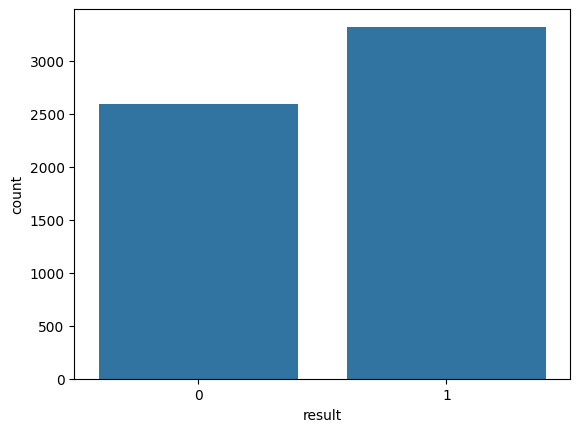

In [ ]:
sns.countplot(x="result", data=df)

In [ ]:
print (df[['home_favorite', 'result']].groupby(['home_favorite'], as_index=False).mean())

   home_favorite    result
0              0  0.353688
1              1  0.671056


In [ ]:
print (df[['away_favorite', 'result']].groupby(['away_favorite'], as_index=False).mean())

   away_favorite    result
0              0  0.669992
1              1  0.350075


<Axes: xlabel='result', ylabel='team_home_current_win_pct'>

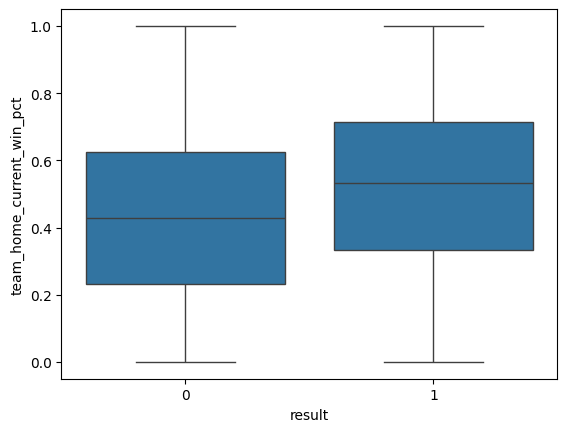

In [ ]:
sns.boxplot(x="result", y="team_home_current_win_pct", data=df)

<Axes: xlabel='result', ylabel='team_home_lastseason_win_pct'>

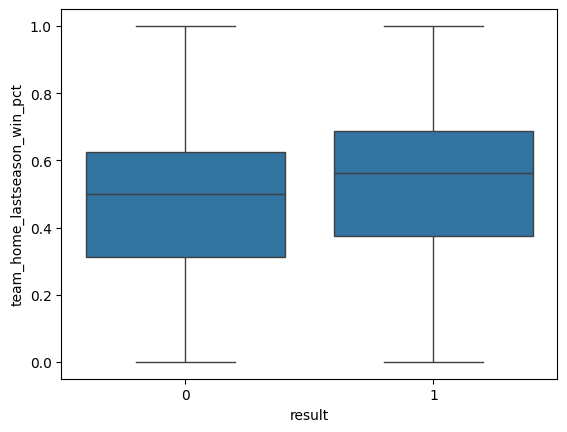

In [ ]:
sns.boxplot(x="result", y="team_home_lastseason_win_pct", data=df)

**Slight positive correlation between team with higher current record and elo prob**

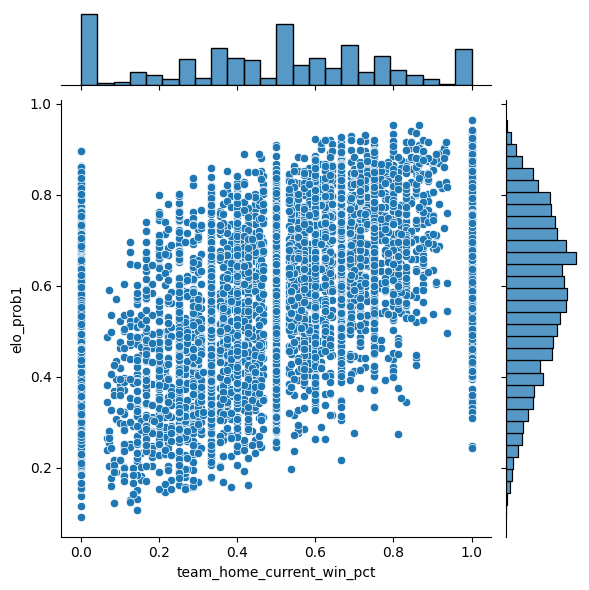

In [ ]:
sns.jointplot(x='team_home_current_win_pct', y='elo_prob1', data=df)

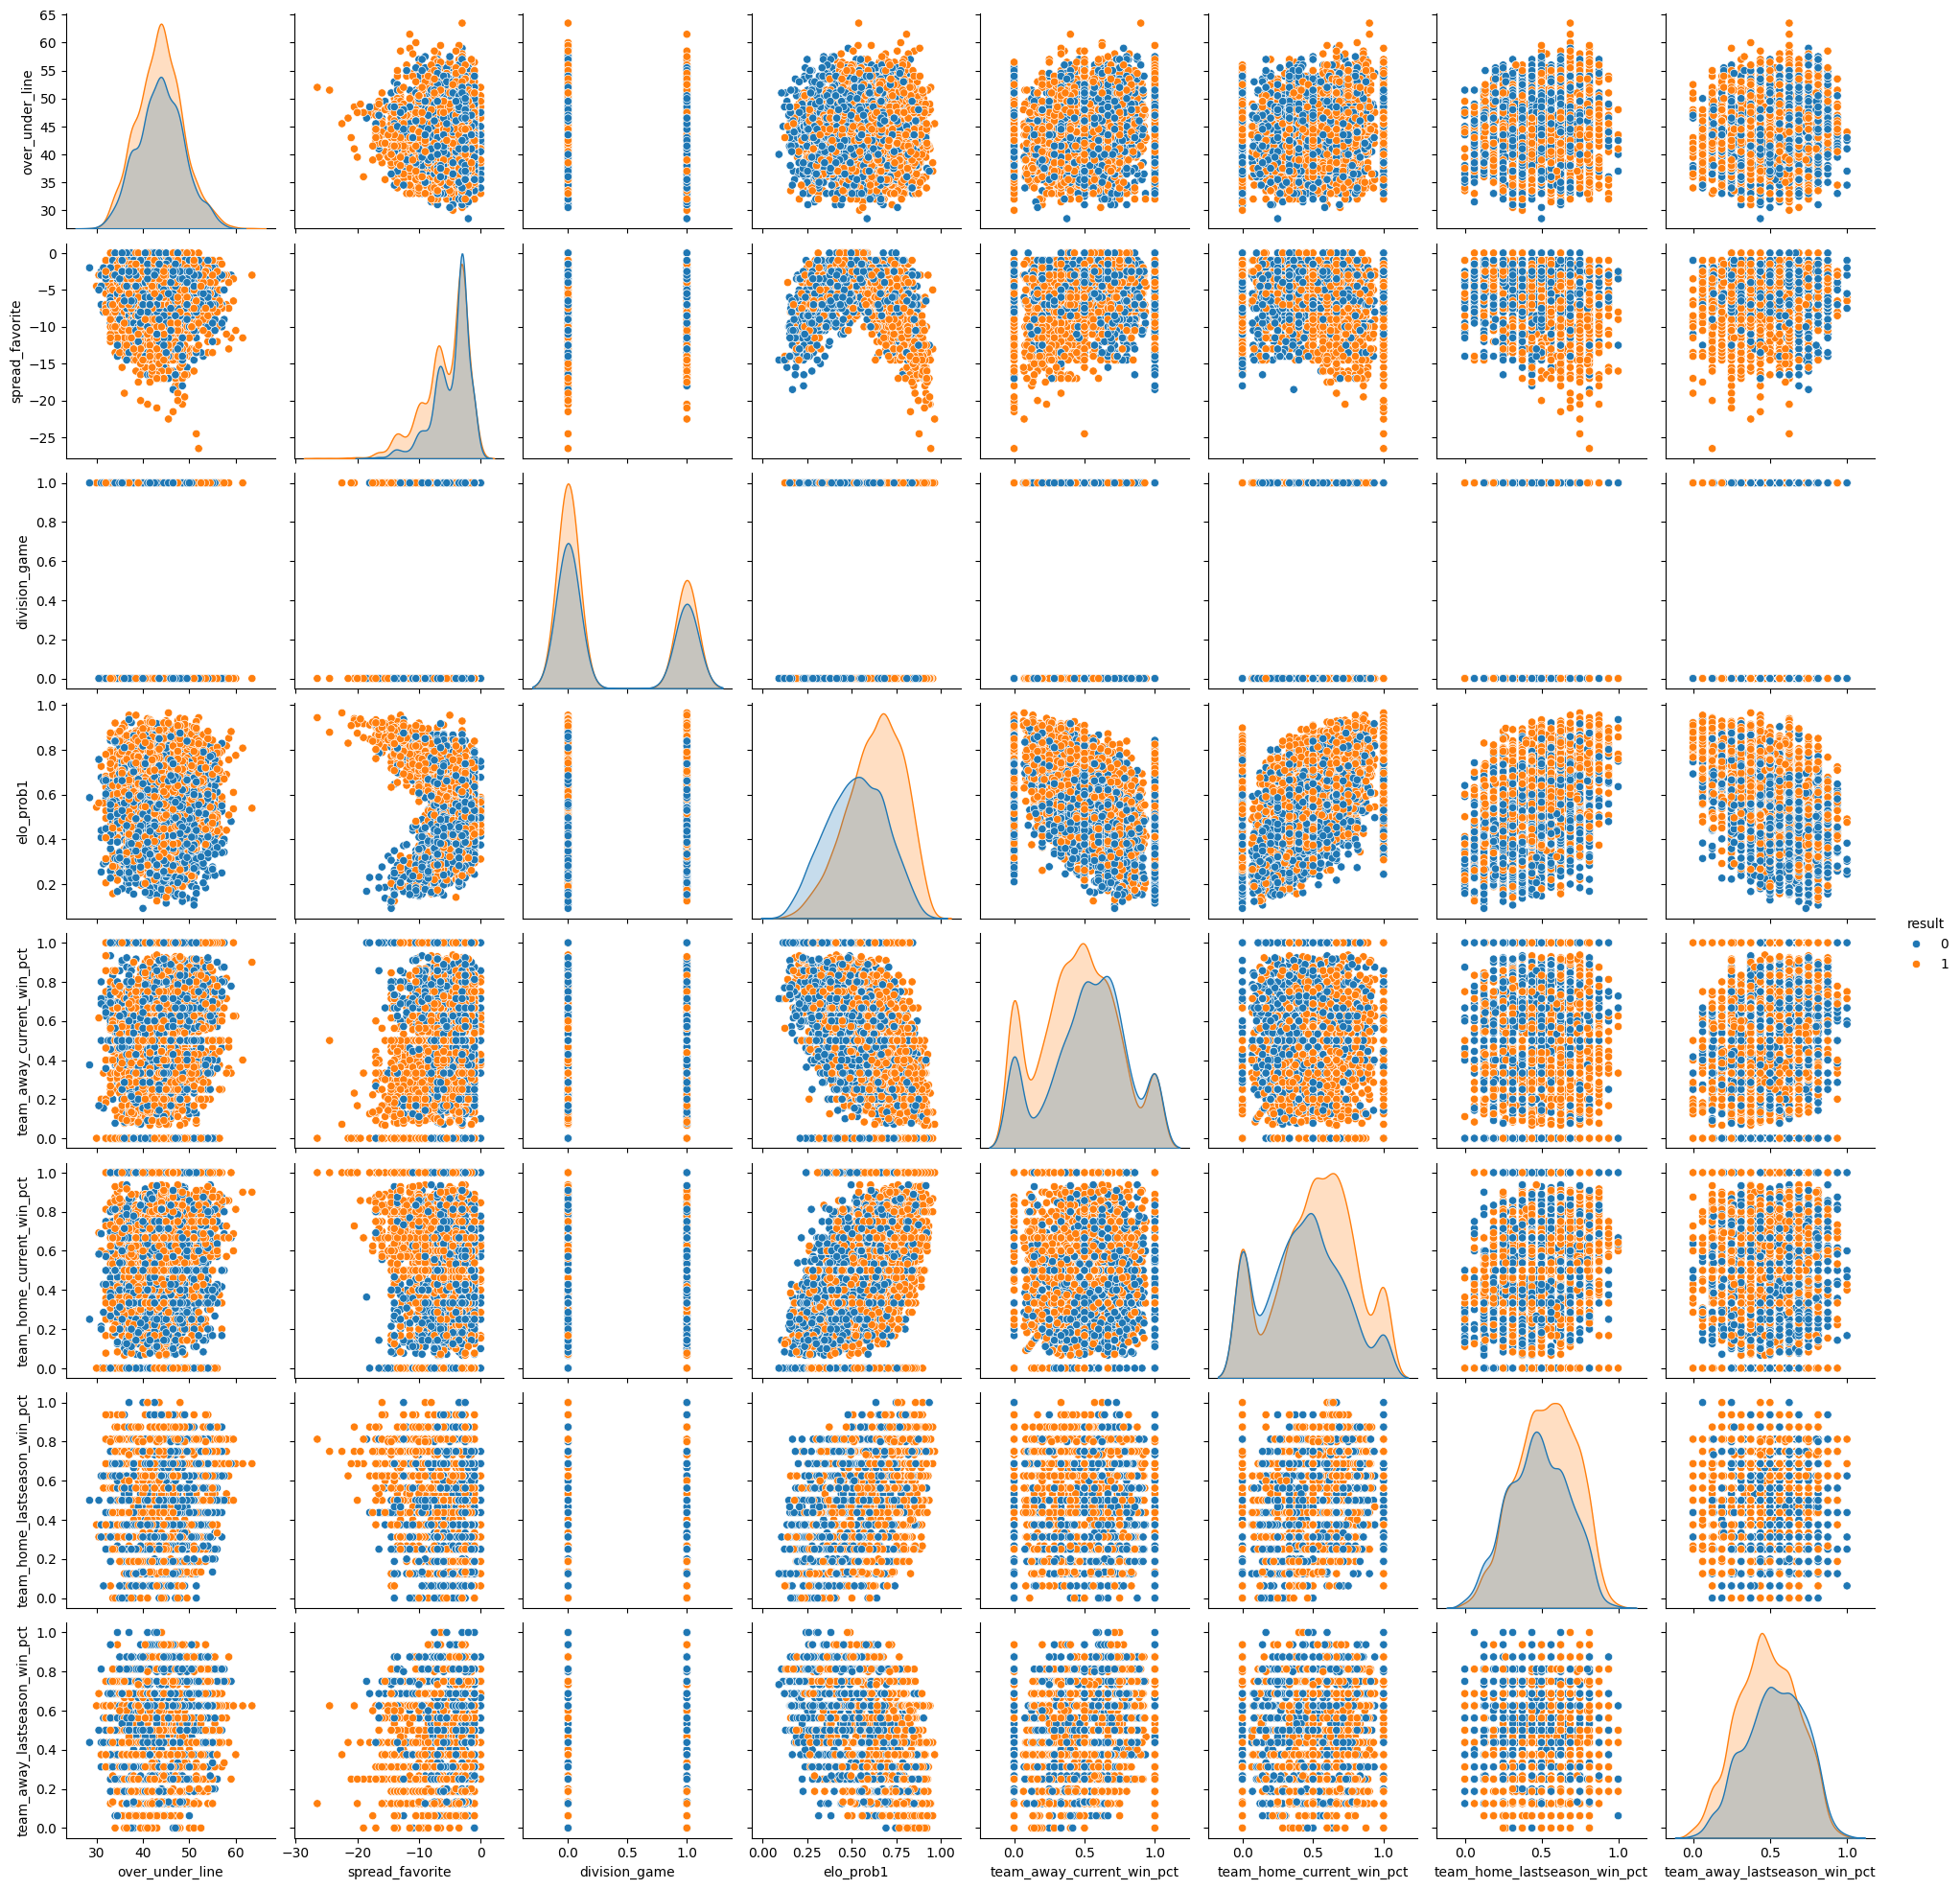

In [ ]:
sns.pairplot(df[[ 'over_under_line', 'spread_favorite', 'division_game', 'elo_prob1',
                 'team_away_current_win_pct', 'team_home_current_win_pct', 'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct', 'result']], hue='result', height=2.5);

**Correlations between variables**

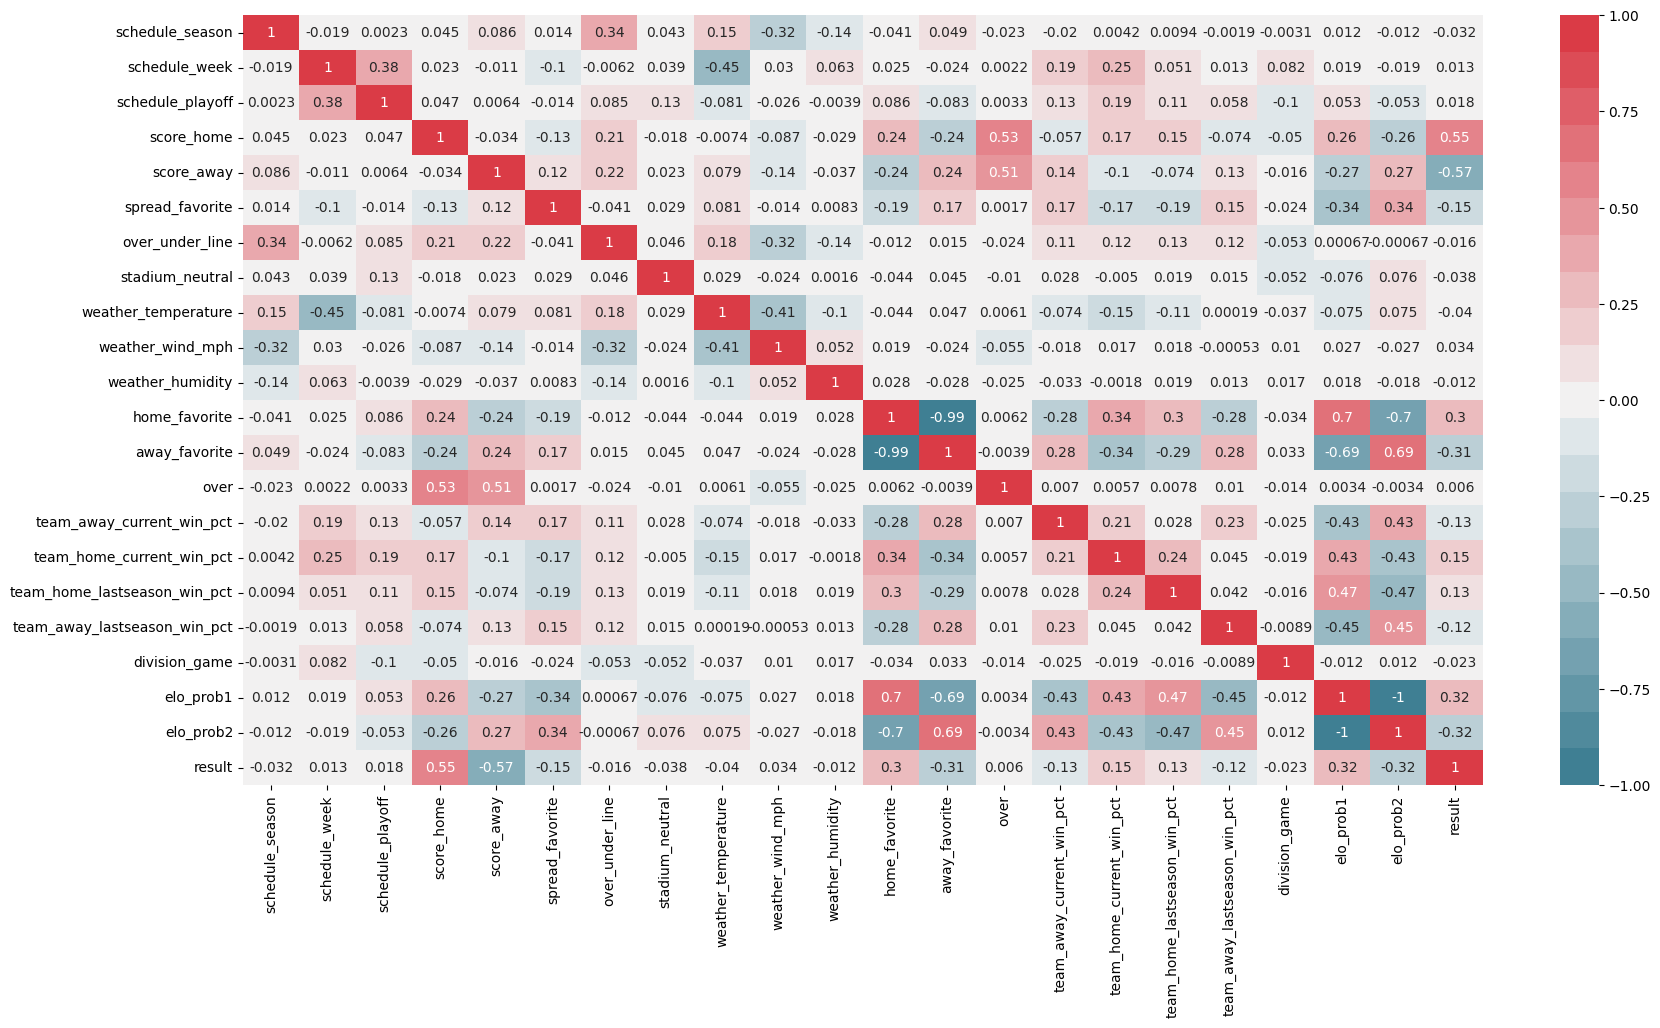

In [ ]:
df['schedule_date'] = pd.to_datetime(df['schedule_date'])

# Extract relevant features for correlation analysis
numerical_df = df.select_dtypes(include=['number'])

plt.figure(figsize = (20,10))
ax2 = sns.heatmap(numerical_df.corr(),annot=True, vmin=-1,vmax=1,cmap=sns.diverging_palette(h_neg=220,h_pos=10,n=21))


## Feature and Model Testing
Predict probability the the Home team will win p(y=1; x)

In [ ]:
df.columns.values

array(['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'home_favorite', 'away_favorite', 'over',
       'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct',
       'team_home_division', 'team_away_division', 'division_game',
       'elo_prob1', 'elo_prob2', 'result'], dtype=object)

* **Training data: [2001-2015]** (15 seasons)  - Validation will be part of the training set
* **Test data: [2016-2018]** (3 seasons)

In [ ]:
# training and testing data
train = df.copy()
test = df.copy()
train = train.loc[train['schedule_season'] < 2022]
test = test.loc[test['schedule_season'] > 2023]

X_train = train[['schedule_week','spread_favorite', 'over_under_line', 'home_favorite','team_away_current_win_pct', 'team_home_current_win_pct',
                 'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct', 'division_game', 'elo_prob1']]
y_train = train['result']

X_test = test[['schedule_week', 'spread_favorite', 'over_under_line', 'home_favorite','team_away_current_win_pct', 'team_home_current_win_pct',
               'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct', 'division_game', 'elo_prob1']]
y_test = test['result']

In [ ]:
# prepare models
models = []

# Classifiers to use in Voting
boost = xgb.XGBClassifier()
dtc = DecisionTreeClassifier(max_depth=5, criterion='entropy')
lrg = LogisticRegression(solver='liblinear')
vote = VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')

models.append(('LRG', LogisticRegression(solver='liblinear', max_iter=250)))
models.append(('KNB', KNeighborsClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('XGB', xgb.XGBClassifier(random_state=0)))
models.append(('RFC', RandomForestClassifier(random_state=0, n_estimators=100)))
models.append(('DTC', DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=5)))
models.append(('SVC', LinearSVC(random_state=0)))
models.append(('VOTE', VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')))
models.append(('CCV', CCV(vote, method='isotonic', cv=3)))
models.append(('MLP', MLPClassifier()))
models.append(('ADA', AdaBoostClassifier(random_state=0)))

# evaluate each model by average of roc auc
results_dict = {}

for name, m in models:
    kfold = model_selection.KFold(n_splits=5)
    cv_results = model_selection.cross_val_score(m, X_train, y_train, cv=kfold, scoring = 'roc_auc') # or 'accuracy'
    results_dict.update({name: "%f" % cv_results.mean()})

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

In [ ]:
# results_dict
sorted(((v,k) for k,v in results_dict.items()), reverse=True)

[('0.698434', 'MLP'),
 ('0.697727', 'SVC'),
 ('0.696867', 'LRG'),
 ('0.696604', 'CCV'),
 ('0.692204', 'GNB'),
 ('0.691252', 'VOTE'),
 ('0.686211', 'DTC'),
 ('0.685798', 'ADA'),
 ('0.674511', 'RFC'),
 ('0.651481', 'XGB'),
 ('0.599928', 'KNB')]

In [ ]:
# Fit best model to all of training set
vote = VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')
model = vote.fit(X_train, y_train)

In [ ]:
X_test.to_csv(path+"test.csv", index=False)

In [ ]:
# predict probabilities
predicted = model.predict_proba(X_test)[:,1]

In [ ]:
print(X_test)

      schedule_week  spread_favorite  over_under_line  home_favorite  \
5805              1             -3.0             47.0              1   
5806              1             -2.0             49.5              1   
5807              1             -3.5             42.0              1   
5808              1             -6.5             46.5              1   
5809              1             -4.0             44.5              1   
...             ...              ...              ...            ...   
5914              8             -4.0             46.0              1   
5915              8             -3.0             46.5              0   
5916              8             -2.5             46.5              0   
5917              8             -1.5             43.5              0   
5918              8             -6.5             36.0              1   

      team_away_current_win_pct  team_home_current_win_pct  \
5805                   0.000000                   0.000000   
5806       

In [ ]:
# predict home team win or lose (0/1)
predictions = model.predict(X_test)


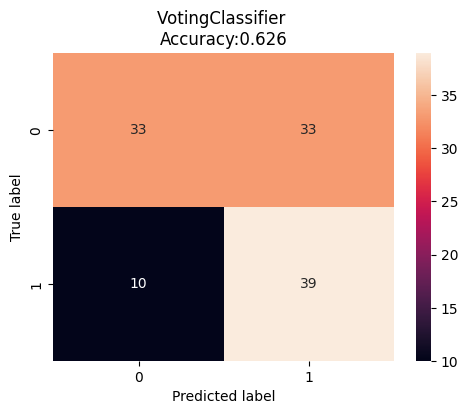

In [ ]:
cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm, annot=True, fmt="g")
plt.title('VotingClassifier \nAccuracy:{0:.3f}'.format(model.score(X_test, y_test)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

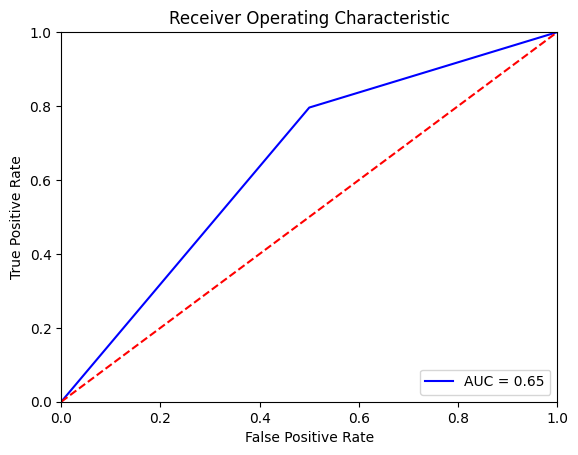

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# method I: plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#model.get_params
#model.coef_

In [ ]:
# ROC AUC Score higher is better while Brier Score the lower the better
print("Metrics" + "\t\t" + "My Model" + "\t" + "Elo Results")
print("ROC AUC Score: " +  "\t" + "{:.4f}".format(roc_auc_score(y_test, predicted)) + "\t\t" + "{:.4f}".format(roc_auc_score(test.result, test.elo_prob1)))
print("Brier Score: " + "\t" + "{:.4f}".format(brier_score_loss(y_test, predicted)) + "\t\t" + "{:.4f}".format(brier_score_loss(test.result, test.elo_prob1)))

Metrics		My Model	Elo Results
ROC AUC Score: 	0.6528		0.6395
Brier Score: 	0.2467		0.2565


## Debugging Training Process

**Plot Learning Curves to diagnoise Bias and Variance to reduce error**

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

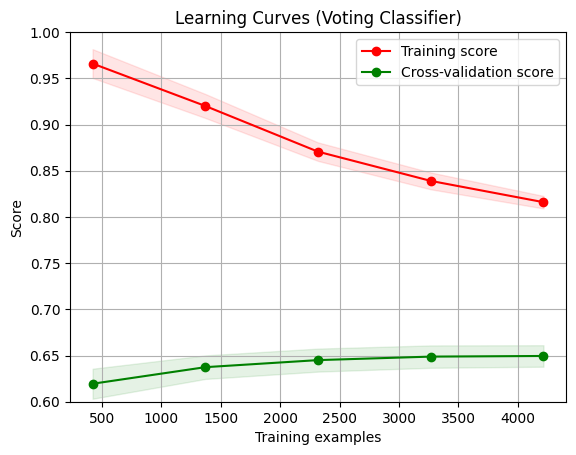

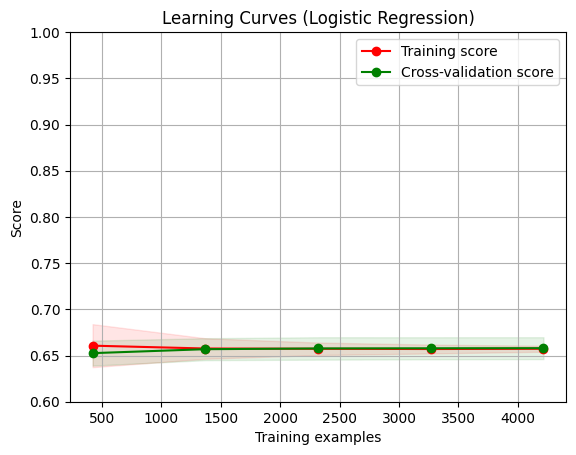

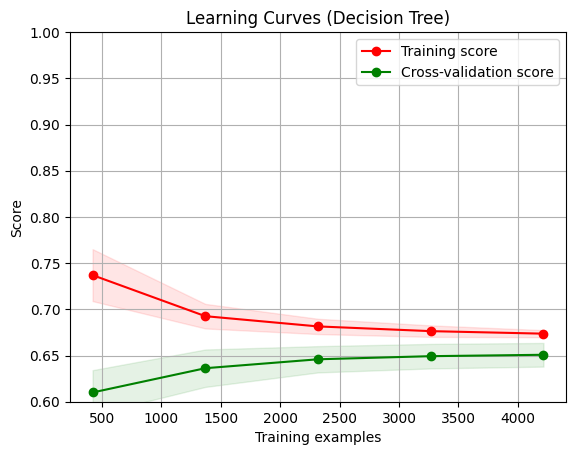

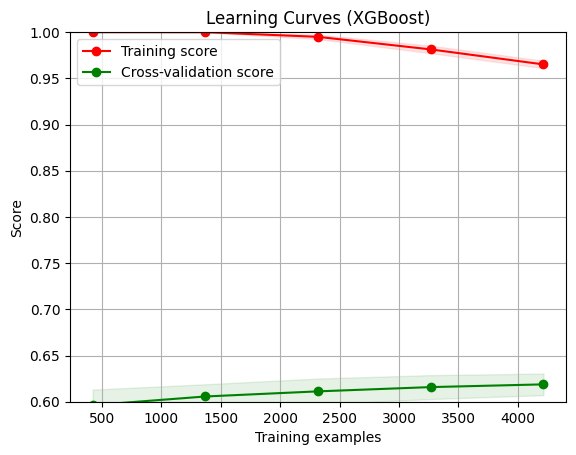

In [ ]:
title = "Learning Curves (Voting Classifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
vote = VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')
plot_learning_curve(vote, title, X_train, y_train, ylim=(0.6, 1.00), cv=cv, n_jobs=4)

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
lrg = LogisticRegression(solver='liblinear')
plot_learning_curve(lrg, title, X_train, y_train, ylim=(0.6, 1.00), cv=cv, n_jobs=4)

title = "Learning Curves (Decision Tree)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
dtc = DecisionTreeClassifier(max_depth=5, criterion='entropy')
plot_learning_curve(dtc, title, X_train, y_train, ylim=(0.6, 1.00), cv=cv, n_jobs=4)

title = "Learning Curves (XGBoost)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
boost = xgb.XGBClassifier()
plot_learning_curve(boost, title, X_train, y_train, ylim=(0.6, 1.00), cv=cv, n_jobs=4)

plt.show()

The Voting Classifier learning curve shows that the model has low variance due the relatively small gap between training and cross-validation score (accuracy).

The score seems to plateau at around 0.66. By addding more data the score could potentially increase by a couple percentages.

Some steps we can take to increase the score:
* Adding more training instances (not like to improve much)
* Adding more features
* Feature selection
* Hyperparameter optimization

## Bets simulation
**Strategy: Bet if probability of team winning >= 60%**

**Compare the model vs. Elo model**

In [ ]:
test.loc[:,'hm_prob'] = predicted
test.loc[:,'hm_pred'] = predictions
# test = test[['schedule_season', 'schedule_week', 'team_home', 'team_away', 'elo_prob1', 'hm_prob', 'result']]

In [ ]:
# calulate bets won (only make a bet when probability is greater than / equal to 60% or less than / equal to 40%)
test['my_bet_won'] = (((test.hm_prob >= 0.60) & (test.result == 1)) | ((test.hm_prob <= 0.40) & (test.result == 0))).astype(int)
test['elo_bet_won'] = (((test.elo_prob1 >= 0.60) & (test.result == 1)) | ((test.elo_prob1 <= 0.40) & (test.result == 0))).astype(int)

# calulate bets lost (only make a bet when probability is greater than / equal to 60% or less than / equal to 40%)
test['my_bet_lost'] = (((test.hm_prob >= 0.60) & (test.result == 0)) | ((test.hm_prob <= 0.40) & (test.result == 1))).astype(int)
test['elo_bet_lost'] = (((test.elo_prob1 >= 0.60) & (test.result == 0)) | ((test.elo_prob1 <= 0.40) & (test.result == 1))).astype(int)

In [ ]:
# printing some quick overall results for my model
print("My Model Win Percentage: " + "{:.4f}".format(test.my_bet_won.sum() / (test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Total Number of Bets Won: " + str(test.my_bet_won.sum()))
print("Total Number of Bets Made: " + str((test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Possible Games: " + str(len(test)))

My Model Win Percentage: 0.6267
Total Number of Bets Won: 47
Total Number of Bets Made: 75
Possible Games: 115


In [ ]:
# printing some quick overall results for fivethirtyeight's ELO model
print("ELO Model Win Percentage: " + "{:.4f}".format(test.elo_bet_won.sum()/(test.elo_bet_lost.sum() + test.elo_bet_won.sum())))
print("Total Number of Bets Won: " + str(test.elo_bet_won.sum()))
print("Total Number of Bets Made: " + str((test.elo_bet_lost.sum() + test.elo_bet_won.sum())))
print("Possible Games: " + str(len(test)))

ELO Model Win Percentage: 0.5938
Total Number of Bets Won: 38
Total Number of Bets Made: 64
Possible Games: 115


**Our model beats the ELO model by 2.6%. while making bets on more games.**

In [ ]:
bets = test[['schedule_date','schedule_season','schedule_week','team_home','score_home','score_away','team_away',
             'team_favorite_id','spread_favorite','over_under_line','stadium','elo_prob1','elo_prob2','result',
             'hm_prob','hm_pred','my_bet_won','elo_bet_won','my_bet_lost','elo_bet_lost']]


bets.to_csv(path+"bets.csv", index=False)

In [ ]:
# creating week by week results
results_df = test.groupby(['schedule_season', 'schedule_week']).agg({'team_home' : 'count', 'my_bet_won' : 'sum',
'elo_bet_won' : 'sum', 'my_bet_lost' : 'sum', 'elo_bet_lost' : 'sum'}).reset_index().rename(columns={'team_home' : 'total_games'})

# counting total bets for my model and the ELO model (prob >= 60% or prob <= 40%)
results_df['total_bets'] = results_df.my_bet_won + results_df.my_bet_lost
results_df['elo_total_bets'] = results_df.elo_bet_won + results_df.elo_bet_lost

# creating accuracy columns based on bets made not on total games
results_df['bet_accuracy'] = round((results_df.my_bet_won / results_df.total_bets) * 100, 2)
results_df['elo_bet_accuracy'] = round((results_df.elo_bet_won / results_df.elo_total_bets) * 100, 2)
results_df = results_df[['schedule_season', 'schedule_week', 'bet_accuracy', 'elo_bet_accuracy',
                         'total_bets', 'elo_total_bets', 'total_games']]

In [ ]:
results_df

schedule_season  schedule_week  bet_accuracy  elo_bet_accuracy  total_bets  \
0             2024              1         80.00             90.00          10   
1             2024              2         44.44             50.00           9   
2             2024              3         28.57             58.33           7   
3             2024              4         60.00             57.14          10   
4             2024              5         66.67             50.00           9   
5             2024              6         88.89             71.43           9   
6             2024              7        100.00             83.33           7   
7             2024              8         42.86             20.00          14   

   elo_total_bets  total_games  
0              10           15  
1               6           15  
2              12           15  
3               7           15  
4               6           13  
5               7           13  
6               6           14  
7              10           15

In [ ]:
test.to_csv(path+"test.csv", index=False)

---
## Resources/Acknowledgements

* NFL Scores and Betting data: https://www.kaggle.com/tobycrabtree/nfl-scores-and-betting-data/home
* NFL Elo data: https://github.com/fivethirtyeight/data/tree/master/nfl-elo
* NFL Betting codes: https://www.kaggle.com/twalters20/nfl-betting-model
* Using Machine Learning for Predicting NFL Games: https://www.youtube.com/watch?v=8emUyzczThY&t=896s
* Predicting Point Spread in NFL Games: http://cs229.stanford.edu/proj2016/report/WadsworthVera-PredictingPointSpreadinNFLGames-report.pdf